In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import math
# dataset='census13'
# version='original'

plt.rcParams['axes.linewidth']=3
plt.rcParams['font.size']=18
plt.rcParams['lines.linewidth']=3

In [2]:
a=[1,2,3,4,5]
print(a[3:])
print(a[:3])

[4, 5]
[1, 2, 3]


In [3]:
def q_error_distribution():
    plt.rcParams['axes.linewidth']=3
    plt.rcParams['font.size']=22
    plt.rcParams['lines.linewidth']=4
    
    workloads=['job-light','scale','synthetic']
    markers=['d','^',"."]
    colors=['']
    

    
    
    
    for th in range(len(workloads)):
        plt.subplots(1,2,figsize=(12,4))
        plt.subplots_adjust(left=0,right=1,top=1,bottom=0,wspace=0.4,hspace=0.3)
#         estimator=estimators[th]
#         result_addr="./lecarb/estimator/predict_result/"+estimator+"_model_prediction/test_"+dataset+"_"+version+".pkl"
        result_addr="./lecarb/estimator/mine/multi_learning_prediction/"+workloads[th]+".pkl"
        with open(result_addr, 'rb') as f:
            [pres,labels,cards] = pickle.load(f)
        pres=pres.cpu().detach().numpy()
#         print(pres[:5])
#         print(labels[:5])
#         print(cards[:5])
        
        int_pres=pres*cards
        int_labels=labels*cards
        
        int_pres=[int(i[0]) for i in int_pres]
        int_labels=[int(i[0]) for i in int_labels]
        labels=[i[0] for i in labels]
        
        x=[]
        q_error=[]
        absolute_error=[]
        for i in range(len(pres)):
            x.append(labels[i])
            absolute_error.append(abs(int_labels[i]-int_pres[i]))
            if int_pres[i]==0 and int_labels[i]==0:
                q_error.append(1)
            elif int_pres[i]==0:
                q_error.append(int_labels[i])
            elif int_labels[i]==0:
                q_error.append(int_pres[i])
            else:
                q_error.append(max(int_labels[i]/int_pres[i],int_pres[i]/int_labels[i]))
#         print(int_pres[:5])
#         print(int_labels[:5])
#         print(q_error[:5])
#         return
        plt.subplot(121)
        plt.scatter(x,q_error,label=workloads[th],marker=markers[th])
        plt.xlabel('cardinality rate')
        plt.ylabel('q_error')

        plt.subplot(122)
        plt.scatter(x,absolute_error,label=workloads[th],marker=markers[th])
        plt.xlabel('cardinality rate')
        plt.ylabel('absolute error')
        plt.legend(bbox_to_anchor=(1.15,0),loc=3,borderaxespad=0)
    #     plt.savefig("q_error_dist_"+dataset+"_"+version+".png",dpi=600,format='png',bbox_inches='tight')    
        plt.show()
        print(max(absolute_error))
        print(min(absolute_error))


       

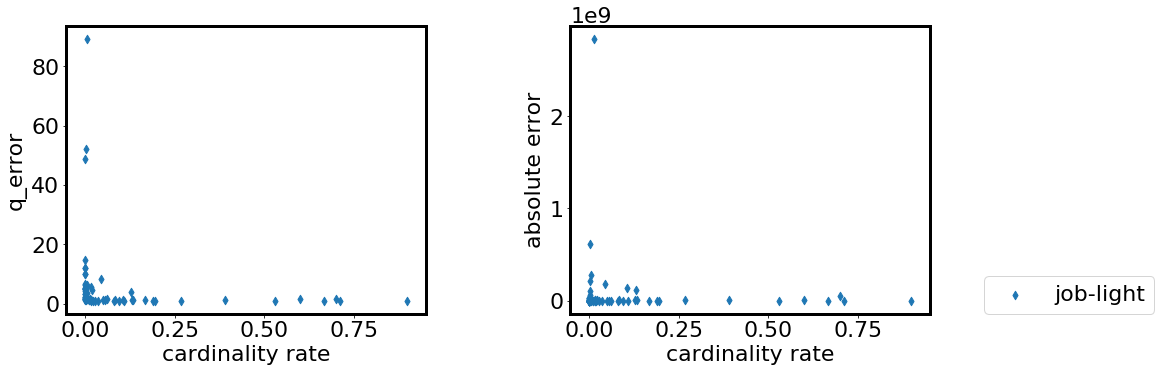

2838013952
4


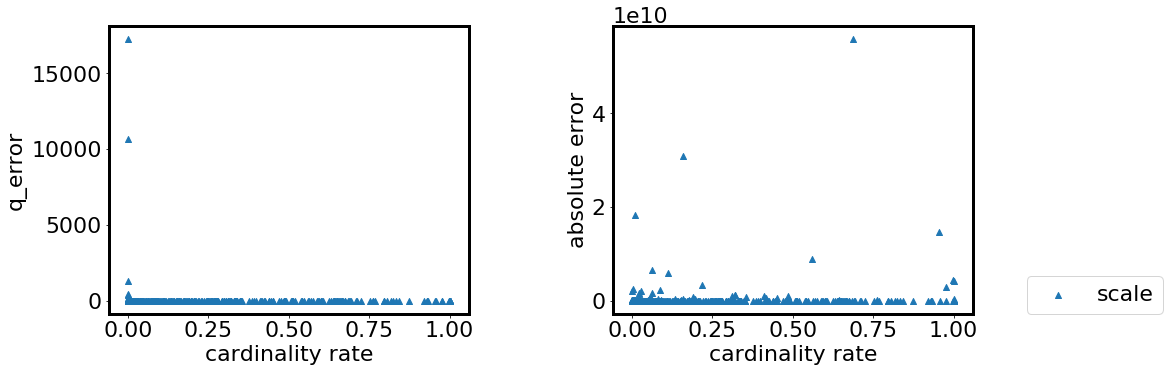

55932190720
1


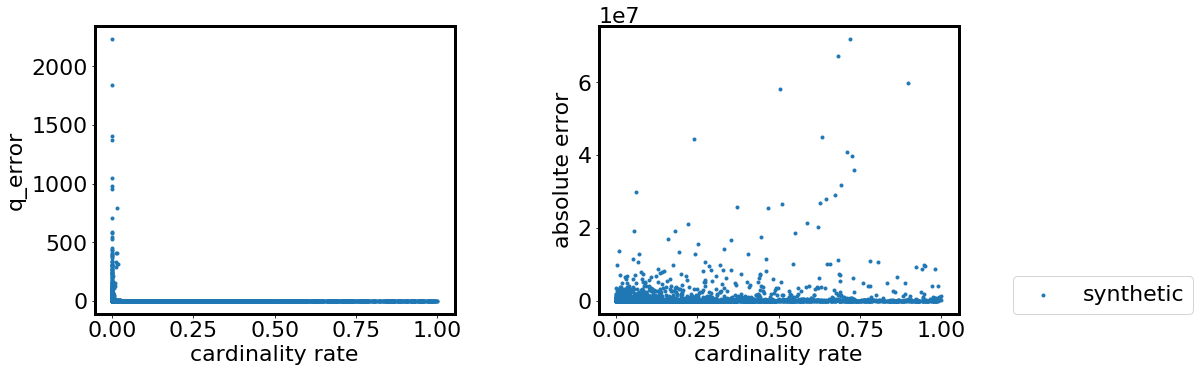

71897408
0


In [4]:
q_error_distribution()

In [5]:
import pickle
import numpy as np
from collections import Counter
import math

# dataset='census1a3'
# version='original'


def drawing():
    numbers=[0,20000,40000,60000,80000]
    
    inference_result=[]
    inference_time=[]
    for number in numbers:
        addr="./lecarb/estimator/mine/multi_inference_result/train-"+str(number)+".pkl"

        with open(addr, 'rb') as f:
            [label,time] = pickle.load(f)
            label=list(label)
            inference_result+=label
            inference_time+=time
    inference_result=inference_result[90000:] # get the log information for valid dataset
    inference_time=inference_time[90000:]
    
    
    result_addr="./lecarb/estimator/mine/multi_learning_prediction/valid.pkl"
    with open(result_addr, 'rb') as f:
        [prediction,label,cards] = pickle.load(f)
                
       
    prediction=prediction.cpu().detach().numpy()
    count_prediction=[float(i) for i in prediction]

    prediction_values=sorted(Counter(count_prediction).keys(),key=lambda x:x,reverse=False)
    
    label=np.around(label*cards)
    label=[i[0] for i in label]
    

    loss=[] # t+q_error
    t=[]
    mean_qerror=[]
    for threshold in prediction_values:
        add_time=0
        q_error=[]
        turn_to_precise=0
        for i in range(len(prediction)):
            if prediction[i]<=threshold:
                q_error.append(1)
                add_time+=inference_time[i]

                turn_to_precise+=1
            else:
                p=np.around(prediction[i]*cards[i])[0]
                
                
                l=label[i]
                if p==0 and l==0:
                    q_error.append(1)
                elif p==0:
                    q_error.append(l)
                elif l==0:
                    q_error.append(p)
                else:
                    q_error.append(max(p/l,l/p))

        add_time=add_time*1000/10000

        loss.append(add_time+np.mean(q_error))
        t.append(add_time)
        mean_qerror.append(np.mean(q_error))
    
    plt.xlabel('eta')
    plt.ylabel('loss')
    plt.plot(prediction_values,loss)
    plt.show()
    
    plt.xlabel('eta')
    plt.ylabel('incremented time of using tree')
    plt.plot(prediction_values,t)
    plt.show()
    
    plt.xlabel('eta')
    plt.ylabel('mean q_error after using tree')
    plt.plot(prediction_values,mean_qerror)
    plt.show()
    
    return prediction_values,loss,t,mean_qerror

In [6]:
import numpy as np
from scipy.optimize import curve_fit,minimize
import matplotlib.pyplot as mpl

from sympy import symbols, diff
from sympy.functions import exp

def func1_for_diff(a,x0,sigma):
    x=symbols('x')
    f=a*exp(-(x-x0)**2/(2*sigma**2))
    derivative_f = diff(f, x)
    return f,derivative_f

def func2_for_diff(a,x0,sigma):
    x=symbols('x')
    f=a*exp(-(x-x0)**2/(2*sigma**2))+1
    derivative_f = diff(f, x)
    return f,derivative_f

# Let's create a function to model and create data
def func1(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def func2(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))+1

def exponen(x,a,b,lamb):
    if type(x)==type([]):
        x=np.array(x)
    return a-b*np.exp(-(lamb*x))

def exponen_for_diff(a,b,lamb):
    x=symbols('x')
    f=a-b*exp(-(lamb*x))
    derivative_f = diff(f, x)
    return f,derivative_f

def fit2(x,y,fit_type):
    plt.plot(x, y, c='k', label='data')
    plt.scatter(x, y)
    if fit_type==1:
        popt, pcov = curve_fit(exponen, x, y,maxfev=1000000)
        ym = exponen(x, popt[0], popt[1], popt[2])
    elif fit_type==2:
        popt, pcov = curve_fit(func2, x, y,maxfev=1000000)
        ym = func2(x, popt[0], popt[1], popt[2])
    else:
        print("wrong type")
        return
        
    #popt returns the best fit values for parameters of the given model (func)

    plt.plot(x, ym, c='r', label='fit')
    plt.legend()
    plt.show()
    return popt

def exponent_func(a,b,lamb):
    f=lambda x:a-b*np.exp(-(lamb*x))
    return f

def func2_func(a,x0,sigma):
    f=lambda x:a*np.exp(-(x-x0)**2/(2*sigma**2))+1
    return f



In [7]:
time_rate=pow(math.e,6-1)
print(time_rate)

148.41315910257657


In [8]:
def fit_and_find_best_eta(prediction_values,t,mean_qerror):
    x=symbols('x')
    popt1=fit2(prediction_values,t,fit_type=1)
    popt2=fit2(prediction_values,mean_qerror,fit_type=2)
    f1,_=exponen_for_diff(popt1[0],popt1[1],popt1[2])
    print("a:",popt1[0])
    print('b:',popt1[1])
    print('lambda:',popt1[2])
    f2,_=func2_for_diff(popt2[0],popt2[1],popt2[2])
    print("c:",popt2[0])
    print('x0:',popt2[1])
    print('sigma:',popt2[2])
    f=f1+f2
    rate=pow(math.e,6-1)
#     f=rate*f1+f2
#     f=f1+0.01*rate*f2
    
    print("time",f1)
    print("mean q error",f2)
    print(f)
    print("-----------------")
    
    func_f1=exponent_func(popt1[0],popt1[1],popt1[2])
    func_f2=func2_func(popt2[0],popt2[1],popt2[2])

    func_f=lambda x:func_f1(x)+func_f2(x)
#     func_f=lambda x:func_f1(x)+0.01*rate*func_f2(x)
    result=minimize(func_f,x0=[0.5],method='SLSQP',bounds=[(0,1)])
    
    
    loss=[]
    for i in range(len(t)):
        loss.append(t[i]+mean_qerror[i])
    plt.scatter(prediction_values,loss,label='loss')
    
    a=[i/10000 for i in range(0,10000)]
    b=[f.subs(x,i) for i in a]
    plt.plot(a,b,color='r',label='fit')
    best_eta=result['x'][0]
    print("best eta:",best_eta)

    plt.scatter(best_eta,f.subs(x,best_eta),color='green')
    plt.legend()
    plt.show()
    return best_eta,f.subs(x,best_eta),a,b


def test_for_best_eta(best_eta,workload):
    
    
    inference_result=[]
    inference_time=[]
    
    addr="./lecarb/estimator/mine/multi_inference_result/"+workload+".pkl"

    with open(addr, 'rb') as f:
        [label,time] = pickle.load(f)
        label=list(label)
        inference_result+=label
        inference_time+=time
#     inference_result=inference_result
#     inference_time=inference_time
    
    
    result_addr="./lecarb/estimator/mine/multi_learning_prediction/"+workload+".pkl"
    with open(result_addr, 'rb') as f:
        [prediction,label,cards] = pickle.load(f)          
       
    prediction=prediction.cpu().detach().numpy()
    count_prediction=[float(i) for i in prediction]

    prediction_values=sorted(Counter(count_prediction).keys(),key=lambda x:x,reverse=False)
   
    label=np.around(label*cards)
    label=[i[0] for i in label]
    
    
    add_time=0
    q_error=[]
    turn_to_precise=0
    for i in range(len(prediction)):
        if prediction[i]<=best_eta:
            q_error.append(1)
            turn_to_precise+=1
            add_time+=inference_time[i]
        else:
            p=np.around(prediction[i]*cards[i])[0]
            l=label[i]
            if p==0 and l==0:
                q_error.append(1)
            elif p==0:
                q_error.append(l)
            elif l==0:
                q_error.append(p)
            else:
                q_error.append(max(p/l,l/p))
    add_time=add_time*1000/len(prediction)
    print("max:",np.max(q_error),'99th:',np.percentile(q_error,99),'95th:',np.percentile(q_error,95),'90th:',np.percentile(q_error,90),'75th:',np.percentile(q_error,75),'50th:',np.percentile(q_error,50),'25th:',np.percentile(q_error,25),'mean:',np.mean(q_error))
    print("average incremental time:",add_time,"ms/query")
    print("turn_to_precise",turn_to_precise,"/",len(prediction))
    


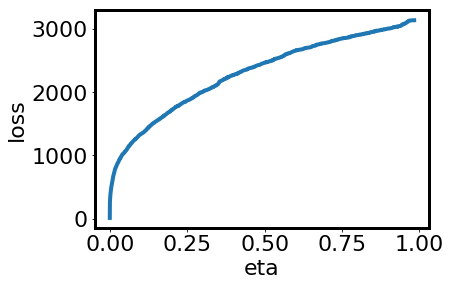

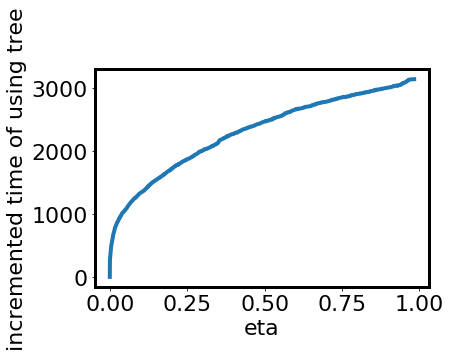

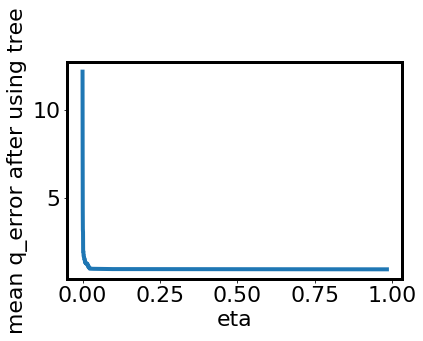

In [9]:
prediction_values,loss,t,mean_qerror=drawing()

/home/lyx15279830673/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp
/home/lyx15279830673/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in multiply


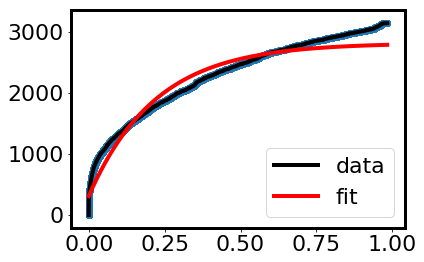

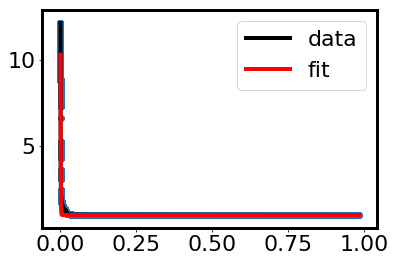

a: 2811.174244586075
b: 2501.359276062944
lambda: 4.5422669685925365
c: 1.090139475776675e+128
x0: -0.37055103938632805
sigma: 0.015318147129151331
time 2811.17424458608 - 2501.35927606294*exp(-4.54226696859254*x)
mean q error 1 + 1.09013947577667e+128*exp(-2130.87282668303*(x + 0.370551039386328)**2)
2812.17424458608 + 1.09013947577667e+128*exp(-2130.87282668303*(x + 0.370551039386328)**2) - 2501.35927606294*exp(-4.54226696859254*x)
-----------------
best eta: 0.0001639672122217379


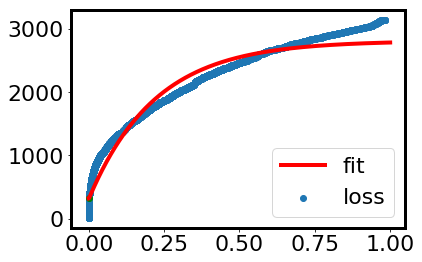

In [10]:
best_eta1,best_loss1,fit_x1,fit_y1=fit_and_find_best_eta(prediction_values,t,mean_qerror)


In [11]:
test_for_best_eta(best_eta1,'job-light')

max: 48.873233795166016 99th: 20.843924999237153 95th: 5.3872452735900875 90th: 4.779593992233276 75th: 1.786159187555313 50th: 1.1089059710502625 25th: 1.0 mean: 2.5001314793314253
average incremental time: 696.1388145174299 ms/query
turn_to_precise 20 / 70


In [12]:
test_for_best_eta(best_eta1,'scale')

max: 1297.0 99th: 9.439011411666852 95th: 2.7850438356399496 90th: 1.7422490715980534 75th: 1.234535664319992 50th: 1.0362914204597473 25th: 1.0038718581199646 mean: 4.099889020204544
average incremental time: 286.59880781173706 ms/query
turn_to_precise 80 / 500


In [13]:
test_for_best_eta(best_eta1,'synthetic')

max: 2233.699951171875 99th: 10.331222858429065 95th: 2.0431362867355354 90th: 1.4718611121177676 75th: 1.1334111094474792 50th: 1.018544614315033 25th: 1.0004505813121796 mean: 4.486935494923592
average incremental time: 192.67145943641663 ms/query
turn_to_precise 1161 / 5000
